In [1]:
import numpy
import random
import cmath
import math
import matplotlib.pyplot as plt

def generate_gray_code(n):
    if n <= 0:
        return ['0']
    if n == 1:
        return ['0', '1']

    prev_gray = generate_gray_code(n - 1)
    result = []
    for code in prev_gray:
        result.append('0' + code)
    for code in reversed(prev_gray):
        result.append('1' + code)
    return result

In [2]:
def symbol_mapper(bin_seq, M, d, name):
    sym_seq = []
    l = int(math.log2(M))
    if name == 'PAM':
        for i in range(int(len(bin_seq)/l)):
            code = bin_seq[i*l:(i+1)*l]
            code_str = ''
            for entry in code:
                code_str +=str(entry)
            gray_code = generate_gray_code(l)
            sym_seq.append((M+1-2*(gray_code.index(code_str)+1))*d/2)
    elif name == 'PSK':
        for i in range(int(len(bin_seq)/l)):
            code = bin_seq[i*l:(i+1)*l]
            code_str = ''
            for entry in code:
                code_str +=str(entry)
            gray_code = generate_gray_code(l)
            m = gray_code.index(code_str)+1
            rEp = d/(2*math.sin(math.pi/M))
            x = complex(rEp*math.cos(2*math.pi*(m-1)/M), rEp*math.sin(2*math.pi*(m-1)/M))
            sym_seq.append(x)
    elif name == 'QAM':
        for i in range(int(len(bin_seq)/l)):
            code = bin_seq[i*l:(i+1)*l]
            code_str = ''
            for entry in code:
                code_str +=str(entry)
            code_front = code_str[:int(l/2)]
            code_back = code_str[int(l/2):]
            gray_code = generate_gray_code(l/2)
            mx = gray_code.index(code_front)+1
            my = gray_code.index(code_back)+1
            rEp = d/2
            x = complex(rEp*(M/2+1-2*mx), rEp*(M/2+1-2*my))
            sym_seq.append(x)
    return sym_seq

In [3]:
# commlab 6-1 testing
# bin_seq = [1, 0, 1, 1, 0, 0, 0, 0]
# sym_seq = symbol_mapper(bin_seq, 16, 1, 'QAM')
# print(sym_seq)

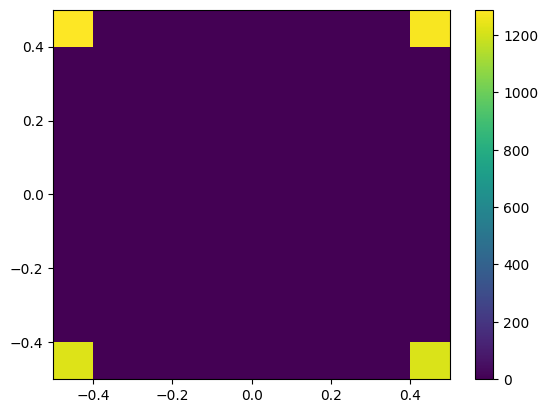

In [4]:
# commlab 6-2a

bin_seq = []
N = 10000
for i in range(N):
    bin_seq.append(int(random.random()+1/2))
sym_seq = symbol_mapper(bin_seq, 4, 1, 'QAM')
# plot the complex numbers
x = [num.real for num in sym_seq]
y = [num.imag for num in sym_seq]
plt.hist2d(x, y)
plt.colorbar()
plt.show()

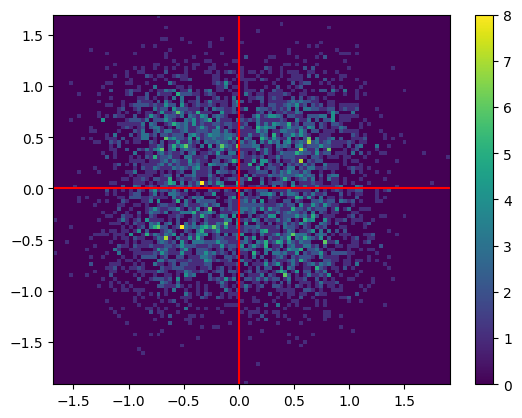

In [5]:
# Commlab 6-2a with noise

Eb = (4-1)/(6*math.log2(4))
# change N_0 with the comments below
# to let Eb/N_0 = 0dB
N_0 = Eb
# to let Eb/N_0 = 10dB
# N_0 = Eb/10
# to let Eb/N_0 = 20dB
# N_0 = Eb/100
noise_seq = []
for num in sym_seq:
    x = complex(num.real+random.gauss(0, math.sqrt(N_0/2)), num.imag+random.gauss(0, math.sqrt(N_0/2)))
    noise_seq.append(x)
# extract real part
x = [num.real for num in noise_seq] 
# extract imaginary part
y = [num.imag for num in noise_seq]
plt.hist2d(x, y, bins = 100)
plt.colorbar()
plt.axhline(y=0, color='r', linestyle='-')
plt.axvline(x=0, color='r', linestyle='-')
plt.show() 

In [6]:
# Commlab 6-2b

def MD_symbol_demapper(sym_seq, M, d, name):
    bin_seq = []
    l = int(math.log2(M))
    gray_code = generate_gray_code(l)
    ref_points = []
    for code in gray_code:
        ref_points += symbol_mapper(code, M, d, name)
    for num in sym_seq:
        min_code = ''
        min_dist = -1
        for i in range(M):
            if name != 'PAM':
                dist = math.sqrt((num.real-ref_points[i].real)**2+(num.imag-ref_points[i].imag)**2)
            elif name == 'PAM':
                dist = math.sqrt((num-ref_points[i])**2)
            if min_dist == -1 or dist < min_dist:
                min_dist = dist
                min_code = gray_code[i]
        for bit in min_code:
            bin_seq.append(int(bit))
    return bin_seq
def SER(a, b, l):
    h = 0
    for i in range(int(len(a)/l)):
        if a[i*l:(i+1)*l] != b[i*l:(i+1)*l]:
            h+=1
    return h/(len(a)/l)

# deocder testing
# decode_seq = MD_symbol_demapper(sym_seq, 4, 1, 'QAM')

# SER for different N_0
decode_seq = MD_symbol_demapper(noise_seq, 4, 1, 'QAM')
print(SER(bin_seq, decode_seq, 2))

0.1658


0.003508301235785466


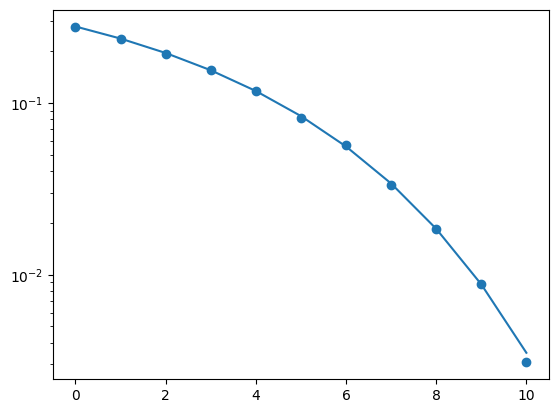

In [7]:
# Commlab 6-3a(PAM)

from scipy import special as sp
def qfunc(x):
    return 0.5-0.5*sp.erf(x/math.sqrt(2))
plt.yscale('log')
N = 100000
# change M
M = 4
Y = []
X = []
for SNR in range(11):
    X.append(SNR)
    bin_seq = []
    for i in range(N):
        bin_seq.append(int(random.random()+1/2))
    sym_seq = symbol_mapper(bin_seq, M, 1, 'PAM')
    noise_seq = []
    Eb = (M*M-1)/(12*math.log2(M))
    N_0 = Eb/(10**(SNR/10))
    for num in sym_seq:
        x = num+random.gauss(0, math.sqrt(N_0/2))
        noise_seq.append(x)
    decode_seq = MD_symbol_demapper(noise_seq, M, 1, 'PAM')
    Y.append(SER(bin_seq, decode_seq, int(math.log2(M))))
Y_theory = []
X = []
for SNR in range(11):
    X.append(SNR)
    xtheory = 2*(M-1)/M*qfunc(math.sqrt((6*math.log2(M)/(M*M-1))*10**(SNR/10)))
    Y_theory.append(xtheory)
# plt.scatter(X,Y)
print(Y_theory[10])
plt.plot(X, Y_theory)
plt.scatter(X,Y)
plt.show()

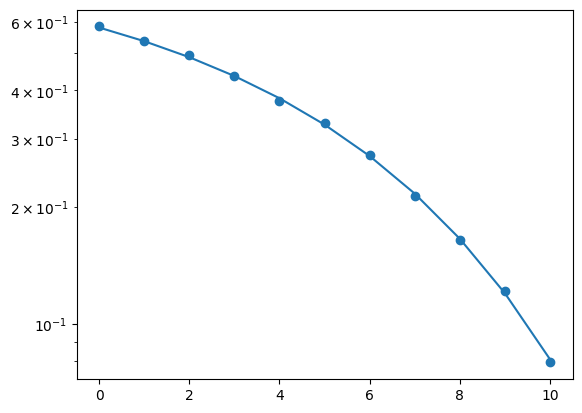

In [8]:
# Commlab 6-3b(PSK)

plt.yscale('log')
N = 100000
# change M
M = 16
Y = []
X = []
for SNR in range(11):
    X.append(SNR)
    bin_seq = []
    for i in range(N):
        bin_seq.append(int(random.random()+1/2))
    sym_seq = symbol_mapper(bin_seq, M, 1, 'PSK')
    noise_seq = []
    Eb = 1/(4*math.log2(M)*(math.sin(math.pi/M)**2))
    N_0 = Eb/(10**(SNR/10))
    for num in sym_seq:
        x = complex(num.real+random.gauss(0, math.sqrt(N_0/2)), num.imag+random.gauss(0, math.sqrt(N_0/2)))
        noise_seq.append(x)
    decode_seq = MD_symbol_demapper(noise_seq, M, 1, 'PSK')
    Y.append(SER(bin_seq, decode_seq, int(math.log2(M))))
Y_theory = []
X = []
for SNR in range(11):
    X.append(SNR)
    xtheory = 2*qfunc(math.sqrt((2*math.log2(M)*(math.sin(math.pi/M)**2))*10**(SNR/10)))
    Y_theory.append(xtheory)
# plt.scatter(X,Y)
plt.plot(X, Y_theory)
plt.scatter(X,Y)
plt.show()

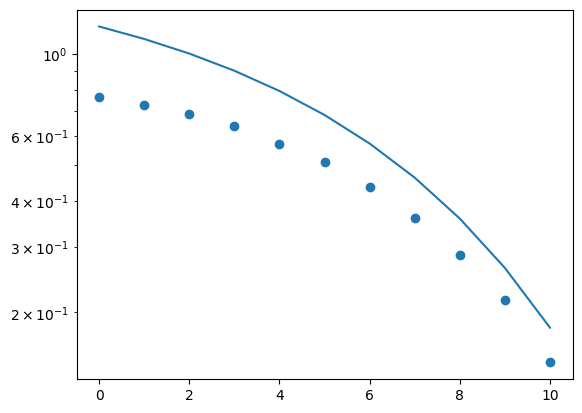

In [9]:
# Commlab 6-3c(QAM)

plt.yscale('log')
N = 100000
# change M
M = 64
Y = []
X = []
for SNR in range(11):
    X.append(SNR)
    bin_seq = []
    for i in range(N):
        bin_seq.append(int(random.random()+1/2))
    sym_seq = symbol_mapper(bin_seq, M, 1, 'QAM')
    noise_seq = []
    Eb = (M-1)/(6*math.log2(M))
    N_0 = Eb/(10**(SNR/10))
    for num in sym_seq:
        x = complex(num.real+random.gauss(0, math.sqrt(N_0/2)), num.imag+random.gauss(0, math.sqrt(N_0/2)))
        noise_seq.append(x)
    decode_seq = MD_symbol_demapper(noise_seq, M, 1, 'QAM')
    Y.append(SER(bin_seq, decode_seq, int(math.log2(M))))
Y_theory = []
X = []
for SNR in range(11):
    X.append(SNR)
    xtheory = 4*qfunc(math.sqrt((3*math.log2(M)/(M-1))*10**(SNR/10)))
    Y_theory.append(xtheory)
# plt.scatter(X,Y)
plt.plot(X, Y_theory)
plt.scatter(X,Y)
plt.show()

In [10]:
def conv_enc(binary_data, impulse_response):
    R_num = len(impulse_response[0])-1
    cur_state = [0 for i in range(R_num)]
    out_num = len(impulse_response)
    c_out = []
    for bit in binary_data:
        cur_c = []
        for g in impulse_response:
            c_sum = g[0]*bit
            for i in range(R_num):
                if g[i+1] == 1:
                    c_sum += cur_state[i]
            if c_sum%2 == 1:
                cur_c.append(1)
            else:
                cur_c.append(0)
        c_out += cur_c
        temp = cur_state[0]
        for i in range(R_num):
            if i == 0:
                cur_state[0] = bit
            else:
                tempp = cur_state[i]
                cur_state[i] = temp
                temp = tempp
    return c_out

class node:
    def __init__(self):
        self.v = 0
        self.s = []
        self.activated = False
def hamming(a, b):
    h = 0
    for i in range(len(a)):
        if a[i] != b[i]:
            h+=1
    return h

def convolution(bit, x, impulse_response):
    R_num = len(impulse_response[0])-1
    out_num = len(impulse_response)
    c_out = []
    for g in impulse_response:
        val = x
        c_sum = bit*g[0]
        for i in range(R_num):
            last_bit = val%2
            c_sum += last_bit * g[R_num-i]
            val = int(val/2)
        if c_sum%2 == 1:
            c_out.append(1)
        else:
            c_out.append(0)
    return c_out

def conv_dec(binary_data, impulse_response):
    R_num = len(impulse_response[0])-1
    out_num = len(impulse_response)
    bit_len = int(len(binary_data)/out_num)
    x = int(2**(R_num))
    nodes = [[node() for i in range(x)] for j in range(bit_len+1)]
    nodes[0][0].activated = True
    for level in range(bit_len):
        cur_seq = binary_data[level*out_num:(level+1)*out_num]
#         print(cur_seq)
        for i in range(x):
            last_b = int((i*2)/x)
            prev1 = (i*2)%x
            prev2 = prev1 + 1
#             print(prev1)
            v1 = -1
            v2 = -1
            if nodes[level][prev1].activated:
                v1 = nodes[level][prev1].v + hamming(cur_seq, convolution(last_b, prev1, impulse_response))
            if nodes[level][prev2].activated:
                v2 = nodes[level][prev2].v + hamming(cur_seq, convolution(last_b, prev2, impulse_response))
            if v1 == -1:
                if v2 != -1:
                    nodes[level+1][i].v = v2
                    nodes[level+1][i].s.append(prev2)
                    nodes[level+1][i].activated = True
            else:
                if v2 == -1:
                    nodes[level+1][i].v = v1
                    nodes[level+1][i].s.append(prev1)
                    nodes[level+1][i].activated = True
                else:
#                     print(v1, v2)
                    if v1 > v2:
                        nodes[level+1][i].v = v2
                        nodes[level+1][i].s.append(prev2)
                        nodes[level+1][i].activated = True
                    elif v2 > v1:
                        nodes[level+1][i].v = v1
                        nodes[level+1][i].s.append(prev1)
                        nodes[level+1][i].activated = True
                    else:
                        nodes[level+1][i].v = v1
                        nodes[level+1][i].s.append(prev1)
                        nodes[level+1][i].s.append(prev2)
                        nodes[level+1][i].activated = True
    cur_level = bit_len
    cur_node = 0
    b_out = []
    while cur_level > 0:
        b = int(cur_node/(2**int(R_num-1)))
        temp = []
        temp.append(b)
        b_out = temp + b_out
        cur_node = nodes[cur_level][cur_node].s[0]
        cur_level -= 1
    return b_out

In [ ]:
# Commlab 6-4a

N = 100000
# change M
Y0 = []
X0 = []
impulse_response = [[1,0,1],[1,1,1]]
for snr_h in range(11):
    SNR = snr_h/2
    X0.append(SNR)
    bin_seq = []
    for i in range(N):
        bin_seq.append(int(random.random()+1/2))
    conv_seq = conv_enc(bin_seq, impulse_response)
    sym_seq = symbol_mapper(conv_seq, 2, 1, 'PSK')
    noise_seq = []
    Eb = 1/(4*math.log2(2)*(math.sin(math.pi/2)**2))
    N_0 = Eb/(10**(SNR/10))
    for num in sym_seq:
        x = complex(num.real+random.gauss(0, math.sqrt(N_0/2)), num.imag+random.gauss(0, math.sqrt(N_0/2)))
        noise_seq.append(x)
    decode_seq = MD_symbol_demapper(noise_seq, 2, 1, 'PSK')
    info_seq = conv_dec(decode_seq, impulse_response)
    Y0.append(hamming(bin_seq, info_seq)/N)
plt.yscale('log')
plt.plot(X0,Y0)
plt.show()

In [ ]:
# Commlab 6-4b

from scipy.spatial import distance
def conv_dec_soft(binary_data, impulse_response):
    R_num = len(impulse_response[0])-1
    out_num = len(impulse_response)
    bit_len = int(len(binary_data)/out_num)
    x = int(2**(R_num))
    nodes = [[node() for i in range(x)] for j in range(bit_len+1)]
    nodes[0][0].activated = True
    for level in range(bit_len):
        cur_seq = binary_data[level*out_num:(level+1)*out_num]
#         print(cur_seq)
        for i in range(x):
            last_b = int((i*2)/x)
            prev1 = (i*2)%x
            prev2 = prev1 + 1
#             print(prev1)
            v1 = -1
            v2 = -1
            conv1 = convolution(last_b, prev1, impulse_response)
            conv1 = [x-1/2 for x in conv1]
            conv2 = convolution(last_b, prev2, impulse_response)
            conv2 = [x-1/2 for x in conv2]
            if nodes[level][prev1].activated:
                v1 = nodes[level][prev1].v + distance.euclidean(cur_seq, conv1)
            if nodes[level][prev2].activated:
                v2 = nodes[level][prev2].v + distance.euclidean(cur_seq, conv2)
            if v1 == -1:
                if v2 != -1:
                    nodes[level+1][i].v = v2
                    nodes[level+1][i].s.append(prev2)
                    nodes[level+1][i].activated = True
            else:
                if v2 == -1:
                    nodes[level+1][i].v = v1
                    nodes[level+1][i].s.append(prev1)
                    nodes[level+1][i].activated = True
                else:
#                     print(v1, v2)
                    if v1 > v2:
                        nodes[level+1][i].v = v2
                        nodes[level+1][i].s.append(prev2)
                        nodes[level+1][i].activated = True
                    elif v2 > v1:
                        nodes[level+1][i].v = v1
                        nodes[level+1][i].s.append(prev1)
                        nodes[level+1][i].activated = True
                    else:
                        nodes[level+1][i].v = v1
                        nodes[level+1][i].s.append(prev1)
                        nodes[level+1][i].s.append(prev2)
                        nodes[level+1][i].activated = True
    cur_level = bit_len
    cur_node = 0
    b_out = []
    while cur_level > 0:
        b = int(cur_node/(2**int(R_num-1)))
        temp = []
        temp.append(b)
        b_out = temp + b_out
        cur_node = nodes[cur_level][cur_node].s[0]
        cur_level -= 1
    return b_out

In [ ]:
N = 10000
# change M
Y = []
X = []
impulse_response = [[1,0,1],[1,1,1]]
for snr_h in range(11):
    SNR = snr_h/2
    X.append(SNR)
    bin_seq = []
    for i in range(N):
        bin_seq.append(int(random.random()+1/2))
    conv_seq = conv_enc(bin_seq, impulse_response)
    sym_seq = symbol_mapper(conv_seq, 2, 1, 'PSK')
#     print("done1")
    noise_seq = []
    Eb = 1/(4*math.log2(2)*(math.sin(math.pi/2)**2))
    N_0 = Eb/(10**(SNR/10))
    for num in sym_seq:
        x = complex(num.real+random.gauss(0, math.sqrt(N_0/2)), num.imag+random.gauss(0, math.sqrt(N_0/2)))
        noise_seq.append(x)
    info_seq = conv_dec_soft(noise_seq, impulse_response)
    Y.append(hamming(bin_seq, info_seq)/N)
    print("done")
plt.yscale('log')
plt.plot(X,Y)
plt.show()